### Introduction to Preprocessing and Training Stage 

## Preprocessing and Training

In [1]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file

### Load Data

In [2]:
df = pd.read_csv('../data/df_for_modeling_no_decay_weighting.csv')
df.head()

,P_Date,P_Date_str,GMS_Completed,DOW,DOW_num,GMST(m),GMS_pds_l10_dw,GMS_pds_l25_dw,GMS_pds_l40_dw,GMS_pds_l10_stdev,...,Shade_Count,Unusual_Sym,Black_Square_Fill,Outside_Grid,Unchecked_Sq,Uniclue,Duplicate_Answers,Quantum,Wordplay,overall_day_mean_GMST(m)
0,2024-02-10,2024-02-10,1,Saturday,7.0,16.533333,22.473939,22.678667,23.289248,4.981753,...,0,1,0,0,0,0,0,0,6.0,26.505868
1,2024-02-09,2024-02-09,1,Friday,6.0,18.000000,17.519091,17.517333,18.048516,3.542548,...,0,0,0,0,0,0,0,0,6.0,21.438951
2,2024-02-08,2024-02-08,1,Thursday,5.0,15.600000,14.662121,17.007333,19.198943,2.654801,...,0,0,0,0,0,0,0,0,6.0,20.690762
3,2024-02-07,2024-02-07,1,Wednesday,4.0,11.850000,11.543636,12.573333,11.583069,2.224982,...,0,0,0,0,0,0,0,0,2.0,13.254744
4,2024-02-06,2024-02-06,1,Tuesday,3.0,8.716667,7.610606,7.881333,8.097398,1.159902,...,0,0,0,0,0,0,0,0,7.0,9.716916


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1867 entries, 0 to 1866
Data columns (total 48 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   P_Date                                 1867 non-null   object 
 1   P_Date_str                             1867 non-null   object 
 2   GMS_Completed                          1867 non-null   int64  
 3   DOW                                    1867 non-null   object 
 4   DOW_num                                1867 non-null   float64
 5   GMST(m)                                1867 non-null   float64
 6   GMS_pds_l10_dw                         1867 non-null   float64
 7   GMS_pds_l25_dw                         1867 non-null   float64
 8   GMS_pds_l40_dw                         1867 non-null   float64
 9   GMS_pds_l10_stdev                      1867 non-null   float64
 10  GMS_pds_l25_stdev                      1867 non-null   float64
 11  GMS_

### Filter Data

In [161]:
#Remove the first solve period (2018)
df_filter = df.copy()
df_filter = df_filter[df_filter['P_Date_str'].str.contains("2019|2020|2021|2022|2023|2024")]

In [162]:
# Filter to a specific puzzle day
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 1)]) #Sun
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 2)]) #Mon
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 3)]) #Tue
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 4)]) #Wed
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 5)]) #Thu
#df_filter = (df_filter.loc[(df_filter['DOW_num'] == 6)]) #Fri
df_filter = (df_filter.loc[(df_filter['DOW_num'] == 7)]) #Sat

In [163]:
# Strip down to only the features we need to benchmark and the target feature
df_filter = df_filter[['overall_day_mean_GMST(m)', 'GMST(m)']]

In [164]:
df_filter[['GMST(m)']].mean()

GMST(m)    26.505868
dtype: float64

In [165]:
df_filter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267 entries, 0 to 1862
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   overall_day_mean_GMST(m)  267 non-null    float64
 1   GMST(m)                   267 non-null    float64
dtypes: float64(2)
memory usage: 6.3 KB


Creating df variants with only the columns we will need to generate the benchmark models 

In [166]:
df_model1 = df_filter[['overall_day_mean_GMST(m)','GMST(m)']]

In [167]:
#df_model2 = df_filter[['IS1_ST(m)','overall_day_mean_IST(m)']]

In [168]:
df_model1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 267 entries, 0 to 1862
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   overall_day_mean_GMST(m)  267 non-null    float64
 1   GMST(m)                   267 non-null    float64
dtypes: float64(2)
memory usage: 6.3 KB


### Train Test Split

In [169]:
len(df_model1) * .80, len(df_model1) * .20

(213.60000000000002, 53.400000000000006)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(df_model1.drop(columns='GMST(m)'), 
                                                    df_model1['GMST(m)'], test_size=0.20, 
                                                    random_state=47)

In [171]:
y_train.shape, y_test.shape

((213,), (54,))

In [172]:
y_train

805     24.333333
182     18.866667
1225    33.116667
294     31.383333
329     25.283333
          ...    
161     19.883333
1253    25.000000
504     23.983333
1848    22.583333
945     32.516667
Name: GMST(m), Length: 213, dtype: float64

In [173]:
X_train

,overall_day_mean_GMST(m)
805,26.505868
182,26.505868
1225,26.505868
294,26.505868
329,26.505868
...,...
161,26.505868
1253,26.505868
504,26.505868
1848,26.505868


In [174]:
X_train.shape, X_test.shape

((213, 1), (54, 1))

### Pre-Modeling: GMS Mean Solve Time Across All 15x15 Puzzles as Per Solve (GMST) Predictor (aka "Dummy Model")

In [175]:
#Target feature (GMST(m)) training set mean
train_mean = y_train.mean()
train_mean

27.04100156494523

In [176]:
#Fitting dummy regressor to training data (from sklearn). Outputs the training set mean.
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
dumb_reg.constant_

array([[27.04100156]])

In [177]:
y_tr_pred = dumb_reg.predict(X_train)
y_tr_pred[:5]

array([27.04100156, 27.04100156, 27.04100156, 27.04100156, 27.04100156])

In [178]:
y_te_pred = train_mean * np.ones(len(y_test))

#### R-Squared (COD)

In [179]:
#Compute R-squared for target mean on training set (will be zero, since we are calculating mean on training set), and on test set (should be slightly different from zero)
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.24430750604089235)

proportion of the variance for a dependent variable that's explained by our features. It's close to zero for the dummy model as expected.

#### Mean Absolute Error (MAE)

In [180]:
MAEs_dummy = mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)
MAEs_dummy

(5.280436715231397, 5.064284472265695)

#### Mean Squared Error (MSE)

In [181]:
#Calculate the Mean Squared Error (average of the square of the errors)
MSEs_dummy = mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)
MSEs_dummy

(43.78429435419681, 35.65749586586155)

#### Root Mean Squared Error (RMSE)

In [182]:
RMSEs_dummy = np.sqrt(mean_squared_error(y_train, y_tr_pred)), np.sqrt(mean_squared_error(y_test, y_te_pred))
RMSEs_dummy

(6.616970179334104, 5.971389776748922)

Now instead of just guessing with the training set mean across all puzzle days, let's use a few benchmarks that at least take into consideration the default difficulty of a given puzzle based on it's puzzle day.

### Benchmark Linear Model 1: Puzzle Day-Specific, Whole-Sample Mean Global Median Solver (GMS) Solve Time as Sole Predictor of Individual GMSTs 

In [183]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213 entries, 805 to 945
Data columns (total 1 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   overall_day_mean_GMST(m)  213 non-null    float64
dtypes: float64(1)
memory usage: 3.3 KB


In [184]:
lr_pipe = make_pipeline(
    SimpleImputer(strategy='median'), 
    StandardScaler(),
    SelectKBest(f_regression),
    LinearRegression()
)

In [185]:
#Dict of available parameters for linear regression pipe
lr_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'simpleimputer', 'standardscaler', 'selectkbest', 'linearregression', 'simpleimputer__add_indicator', 'simpleimputer__copy', 'simpleimputer__fill_value', 'simpleimputer__missing_values', 'simpleimputer__strategy', 'simpleimputer__verbose', 'standardscaler__copy', 'standardscaler__with_mean', 'standardscaler__with_std', 'selectkbest__k', 'selectkbest__score_func', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [186]:
#Define search grid parameters
k = [k+1 for k in range(len(X_train.columns))]

grid_params = {
    'standardscaler': [StandardScaler(), None],
    'simpleimputer__strategy': ['mean', 'median'],
    'selectkbest__k': k
}

In [187]:
#Call `GridSearchCV` with linear regression pipeline, passing in the above `grid_params`
#dict for parameters to evaluate with 5-fold cross-validation
lr_grid_cv = GridSearchCV(lr_pipe, param_grid=grid_params, cv=5)

In [32]:
#Conduct grid search for this ranking-restricted model. 
lr_grid_cv.fit(X_train, y_train)

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:294: RuntimeWarning: invalid value e

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('selectkbest',
                                        SelectKBest(score_func=<function f_regression at 0x000001BF97314310>)),
                                       ('linearregression',
                                        LinearRegression())]),
             param_grid={'selectkbest__k': [1],
                         'simpleimputer__strategy': ['mean', 'median'],
                         'standardscaler': [StandardScaler(), None]})

In [33]:
#Best params from grid search for this ranking-restricted model
lr_grid_cv.best_params_

{'selectkbest__k': 1,
 'simpleimputer__strategy': 'mean',
 'standardscaler': StandardScaler()}

#### K Best Features Visualization

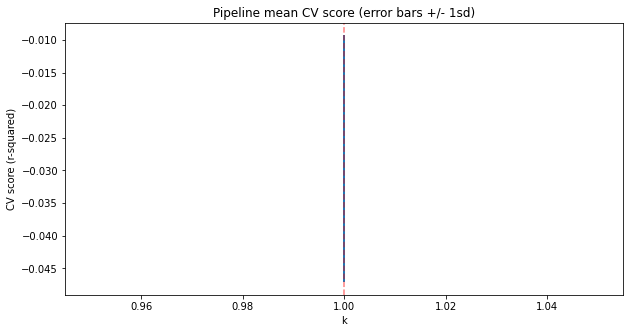

In [34]:
score_mean = lr_grid_cv.cv_results_['mean_test_score']
score_std = lr_grid_cv.cv_results_['std_test_score']
cv_k = [k for k in lr_grid_cv.cv_results_['param_selectkbest__k']]

best_k = lr_grid_cv.best_params_['selectkbest__k']
plt.subplots(figsize=(10, 5))
plt.errorbar(cv_k, score_mean, yerr=score_std)
plt.axvline(x=best_k, c='r', ls='--', alpha=.5)
plt.xlabel('k')
plt.ylabel('CV score (r-squared)')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

### Benchmark Model 1 Metrics

#### R-squared (COD)

In [35]:
#Cross-validation defaults to R^2 metric for scoring regression
lr_best_cv_results = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, cv=5)
lr_best_scores = lr_best_cv_results['test_score']
lr_best_scores

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


array([-0.02970163, -0.00843058, -0.00835473, -0.035618  , -0.05903588])

In [36]:
#Training set CV mean and std
np.mean(lr_best_scores), np.std(lr_best_scores)

(-0.02822816134512953, 0.018935646632623905)

#### Mean Absolute Error (MAE)

In [37]:
lr_neg_mae = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)

In [38]:
# Training set MAE and STD 
lr_mae_mean = np.mean(-1 * lr_neg_mae['test_score'])
lr_mae_std = np.std(-1 * lr_neg_mae['test_score'])
MAE_LR_train = lr_mae_mean, lr_mae_std
MAE_LR_train

(7.019470064398403, 0.6861127789314481)

In [39]:
# Test set mean
MAE_LR_test = mean_absolute_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MAE_LR_test

7.011879804332636

#### Mean Squared Error (MSE)

In [40]:
lr_neg_mse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_mean_squared_error', cv=5)

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [41]:
#Training set CV mean and std
lr_mse_mean = np.mean(-1 * lr_neg_mse['test_score'])
lr_mse_std = np.std(-1 * lr_neg_mse['test_score'])
MSE_LR_train = lr_mse_mean, lr_mse_std
MSE_LR_train

(80.63199731312169, 17.78528629562282)

In [42]:
# Test set mean
MSE_LR_test = mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test))
MSE_LR_test

83.55605178900271

#### Root Mean Square Error (RMSE)

In [43]:
lr_neg_rmse = cross_validate(lr_grid_cv.best_estimator_, X_train, y_train, 
                            scoring='neg_root_mean_squared_error', cv=5)

C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\jraks\anaconda3\lib\site-packages\sklearn\feature_selection\_univariate_selection.py:301: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms


In [44]:
#Training set CV mean and std
lr_rmse_mean = np.mean(-1 * lr_neg_rmse['test_score'])
lr_rmse_std = np.std(-1 * lr_neg_rmse['test_score'])
RMSE_LR_train = lr_rmse_mean, lr_rmse_std
RMSE_LR_train

(8.926003259009553, 0.979011303955433)

In [45]:
# Test set mean
RMSE_LR_test = np.sqrt(mean_squared_error(y_test, lr_grid_cv.best_estimator_.predict(X_test)))
RMSE_LR_test

9.140899944152256

### Best Linear Model Feature Importance

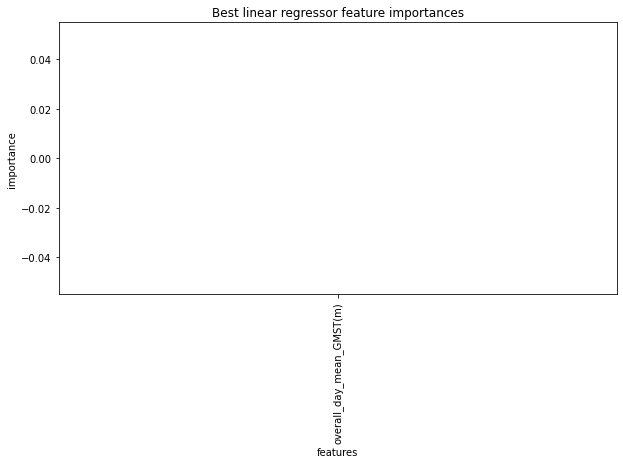

In [46]:
#Plots a barplot of the linear regressor feature importances,
#assigning the `feature_importances_` attribute of 
#`lv_grid_cv.best_estimator_.named_steps.linearregression` to the name `imps` to then
#create a pandas Series object of the feature importances, with the index given by the
#training data column names, sorting the values in descending order
selected = lr_grid_cv.best_estimator_.named_steps.selectkbest.get_support()
plt.subplots(figsize=(10, 5))
imps = lr_grid_cv.best_estimator_.named_steps.linearregression.coef_
lr_feat_imps = pd.Series(imps, index=X_train.columns[selected]).sort_values(ascending=False)
lr_feat_imps.plot(kind='bar')
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best linear regressor feature importances');

### Save Best Linear Model Object From Pipeline

In [47]:
# save the best linear model
best_model = lr_grid_cv.best_estimator_
best_model.version = '1.0'
best_model.pandas_version = pd.__version__
best_model.numpy_version = np.__version__
best_model.sklearn_version = sklearn_version
best_model.X_columns = [col for col in X_train.columns]
best_model.build_datetime = datetime.datetime.now()

modelpath = '../models'
save_file(best_model, 'GMST_benchmark_lm_Sun.pkl', modelpath)

Writing file.  "../models\GMST_benchmark_lm_Sun.pkl"


### Save Prediction Metrics from Dummy Model and Benchmark Model 1

In [48]:
# save other data for model comparisons in machine learning model stage
comp_data_from4_GMST = (MAEs_dummy, MSEs_dummy, RMSEs_dummy, MAE_LR_train, MAE_LR_test, MSE_LR_train, MSE_LR_test, RMSE_LR_train, RMSE_LR_test)
with open('../data/GMST_benchmark_lm_Sun.pickle', 'wb') as f:
    pickle.dump(comp_data_from4_GMST, f)

### Conclusions

 